# Kaggle Competition: Spaceship Titanic

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.

#### Datasets:
- Train: Personal records for about 2/3 of passengers, to be used as training data
- Test: Personal records for the remaining 1/3 of the passengers, to be used as test data. The goal is to predict the value of 'Transported' in this set.

## Metadata

- **PassengerId (str)** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet (str)** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep (bool)** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin (str)** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination (str)** - The planet the passenger will be debarking to.
- **Age (float)** - The age of the passenger.
- **VIP (bool)** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (float)** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name (str)** - The first and last names of the passenger.
- **Transported (bool)** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Loading train set and data cleaning

In [2]:
# Loading dataset

train = pd.read_csv('train.csv')

# split Cabin to extract more information

train['Deck'] = train['Cabin'].str.split(pat='/', expand=True)[0]
train['CabinNum'] = train['Cabin'].str.split(pat='/', expand=True)[1]
train['Side'] = train['Cabin'].str.split(pat='/', expand=True)[2]

# assign dtypes for less memory usage

column_mapper = {
    'HomePlanet':'category',
    'CryoSleep':'bool',
    'Destination':'category',
    'VIP':'bool'
}

train = train.astype(column_mapper).drop('Cabin', axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   8693 non-null   object  
 1   HomePlanet    8492 non-null   category
 2   CryoSleep     8693 non-null   bool    
 3   Destination   8511 non-null   category
 4   Age           8514 non-null   float64 
 5   VIP           8693 non-null   bool    
 6   RoomService   8512 non-null   float64 
 7   FoodCourt     8510 non-null   float64 
 8   ShoppingMall  8485 non-null   float64 
 9   Spa           8510 non-null   float64 
 10  VRDeck        8505 non-null   float64 
 11  Name          8493 non-null   object  
 12  Transported   8693 non-null   bool    
 13  Deck          8494 non-null   object  
 14  CabinNum      8494 non-null   object  
 15  Side          8494 non-null   object  
dtypes: bool(3), category(2), float64(6), object(5)
memory usage: 789.9+ KB


In [3]:
# Proportion of observations with positive y variable, is well represented, won't have this risk for biasing the model

train['Transported'].value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

In [4]:
# Testing to just drop rows with NA values

train_clean = train.dropna(axis=0)
train_clean.shape

(6943, 16)

In [5]:
# After removing Na rows, the same proportion of y-positive is maintained and it doesn't loose significant part of sample

sample_maintained = train_clean.shape[0] / train.shape[0]
print(f'Percentage of sample maintained:',sample_maintained)
train_clean['Transported'].value_counts(normalize=True)

Percentage of sample maintained: 0.798688600023007


Transported
True     0.503961
False    0.496039
Name: proportion, dtype: float64

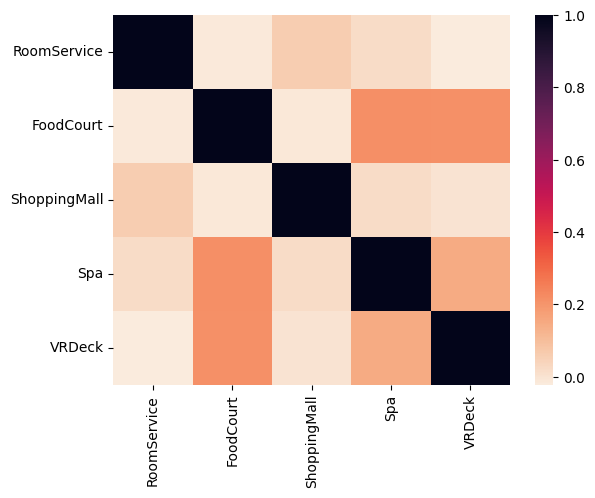

In [6]:
# Checking multicollinearity: not observable in continuous columns

df_continuous = train_clean[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']]
df_continuous_corr = df_continuous.corr()

cmap = sns.cm.rocket_r
sns.heatmap(df_continuous_corr, cmap = cmap)
plt.show()

## Normalizing data

**Normalization vs Standardization**

- Normalization (min-max): scales data to a range from 0 and 1
$$
X_{normal.} = \frac{X-X_{min}}{X_{max}-X_{min}}
$$
- Stardardization: transform data to have a mean ($\mu$) of 0 and standard dev ($\sigma$) of 1
$$
X_{stand.} = \frac{X-\mu}{\sigma}
$$
<br> As Logistic Regression assumes a normal distribution, I'll be using a Z-score standardization

In [7]:
# Z-Score normalize the continuous variables

standard_scaler = StandardScaler()

cont_standard = standard_scaler.fit_transform(df_continuous)
cont_standard

array([[-0.34238591, -0.28512436, -0.30894197, -0.27512286, -0.26835819],
       [-0.17506205, -0.27977129, -0.26477498,  0.20929638, -0.22923897],
       [-0.27637741,  1.84183224, -0.30894197,  5.64996851, -0.22479361],
       ...,
       [-0.34238591, -0.28512436,  2.99828236, -0.27424049, -0.26835819],
       [-0.34238591,  0.3388067 , -0.30894197,  0.03635254,  2.60779324],
       [-0.14896567,  2.50323485, -0.30894197, -0.27512286, -0.25768931]])

From 6943 observations,  4546  are 0 for selected column


<Axes: xlabel='RoomService', ylabel='Count'>

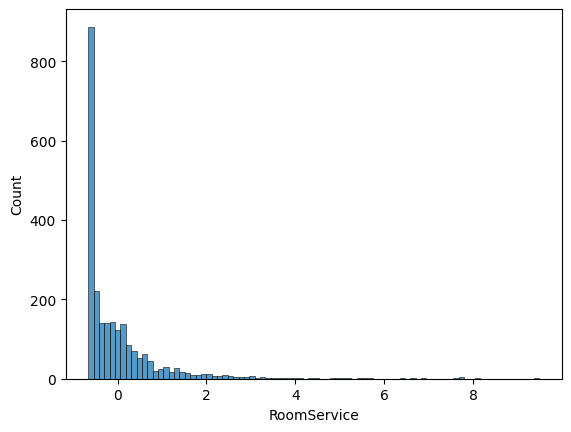

In [8]:
# input: column to check distribution
lookup_col = 'RoomService'

# calculation
df_cont_lookup = df_continuous[df_continuous[lookup_col] > 0]
lookup_standard = standard_scaler.fit_transform(df_cont_lookup)
cont_lookup = pd.DataFrame(lookup_standard, columns=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'])

# output
not_zeros = cont_standard.shape[0] - cont_lookup.shape[0]
print(f'From', cont_standard.shape[0], 'observations, ', not_zeros, ' are 0 for selected column')
sns.histplot(data=cont_lookup, x=lookup_col)

In [9]:
# Convert transported to array to append
transported_arr = train_clean['Transported'].to_numpy()
transported_arr = transported_arr[:, np.newaxis]

# Create df with normalized cont var and transported
X_yappended = np.append(X_standard, transported_arr, axis=1)
cont_standard = pd.DataFrame(X_yappended, columns=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Transported'])
cont_standard.head(3)

NameError: name 'X_standard' is not defined

# Logistic Regression

## Overview

Consists of a Linear Regression, $y$ being the dependent variable and $x_n$ explanatory variables:
$$
y = \beta_0 + \beta_1 X_1 + ...+ \beta_n X_n
$$
Applied into a Sigmoid function:
$$
p = \frac{1}{1+e^{-y}}
$$

<br> Therefore, Logistic regression is similar to linear regression, except that coefficients are in terms of *log(odds)*.
<br> Additionally, to fit the line based on coefficients to observed datapoints, logistic regression uses *Maximum Likelihood Estimation (MLE)* instead of Least Squares Method.
<br> 
<br> Outcome will be a classification between 0 and 1 probability for the y-variable. Here it will be the "Transported" variable.


## Examples

To understand how Logistic Regression works, let's use some columns from the dataset to do an example if continuous data and another with discrete data.

### Continuous variables

Y-axis in logistic regression (between 0 and 1) is transformed from "probability of transported" to "log(odds of transported)", so it will be able to go from -infty to +infty
<br>In chart on the left, we can create a linear regression with coefficients. It works the same, but in a scale of log(odds)
<br>.

<img src="../images/logistic_regression_continuous.png" alt="Continuous Regression" width="800"/>

In [ ]:
cont_standard